In [1]:
import os
from google.colab import drive

# Montar el Google Drive
drive.mount('/content/drive')

# Definir la ruta del dataset
PATH = '/content/drive/MyDrive/Datasets/Stanford Dogs'

# Obtener las clases del dataset
classes = os.listdir(PATH)
print(classes)

Mounted at /content/drive
['miniature_schnauzer', 'malinois', 'Labrador_retriever', 'Lakeland_terrier', 'Mexican_hairless', 'miniature_poodle', 'miniature_pinscher', 'Leonberg', 'malamute', 'Maltese_dog', 'Norfolk_terrier', 'papillon', 'Pekinese', 'Norwich_terrier', 'Pembroke', 'Norwegian_elkhound', 'Newfoundland', 'Old_English_sheepdog', 'Pomeranian', 'otterhound', 'Shih-Tzu', 'Scottish_deerhound', 'redbone', 'Scotch_terrier', 'Rottweiler', 'Siberian_husky', 'Shetland_sheepdog', 'pug', 'Sealyham_terrier', 'Rhodesian_ridgeback', 'standard_poodle', 'standard_schnauzer', 'Tibetan_mastiff', 'silky_terrier', 'Staffordshire_bullterrier', 'Yorkshire_terrier', 'Tibetan_terrier', 'soft-coated_wheaten_terrier', 'whippet', 'Sussex_spaniel']


In [2]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: miniature_schnauzer. Imágenes: 154
Categoría: malinois. Imágenes: 150
Categoría: Labrador_retriever. Imágenes: 171
Categoría: Lakeland_terrier. Imágenes: 197
Categoría: Mexican_hairless. Imágenes: 155
Categoría: miniature_poodle. Imágenes: 155
Categoría: miniature_pinscher. Imágenes: 184
Categoría: Leonberg. Imágenes: 210
Categoría: malamute. Imágenes: 178
Categoría: Maltese_dog. Imágenes: 252
Categoría: Norfolk_terrier. Imágenes: 172
Categoría: papillon. Imágenes: 196
Categoría: Pekinese. Imágenes: 149
Categoría: Norwich_terrier. Imágenes: 185
Categoría: Pembroke. Imágenes: 181
Categoría: Norwegian_elkhound. Imágenes: 196
Categoría: Newfoundland. Imágenes: 195
Categoría: Old_English_sheepdog. Imágenes: 169
Categoría: Pomeranian. Imágenes: 219
Categoría: otterhound. Imágenes: 151
Categoría: Shih-Tzu. Imágenes: 214
Categoría: Scottish_deerhound. Imágenes: 232
Categoría: redbone. Imágenes: 148
Categoría: Scotch_terrier. Imágenes: 158
Categoría: Rottweiler. Imágenes: 152
Catego

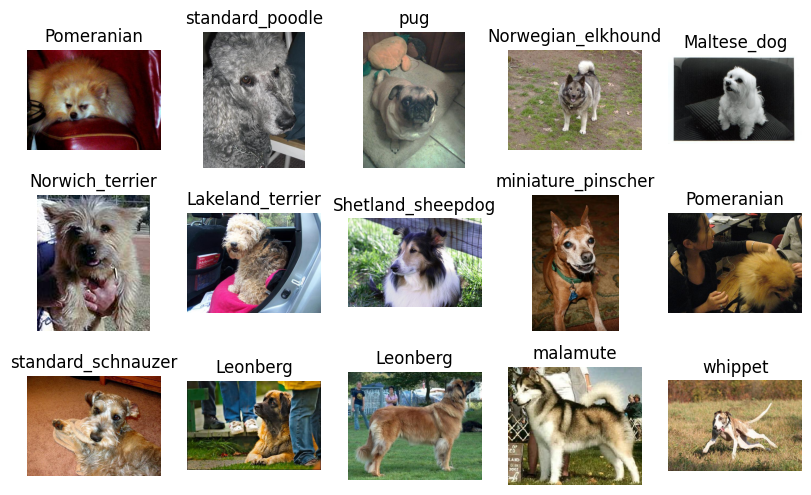

In [3]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(5691, 1423)

In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [6]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(5691, 1423)

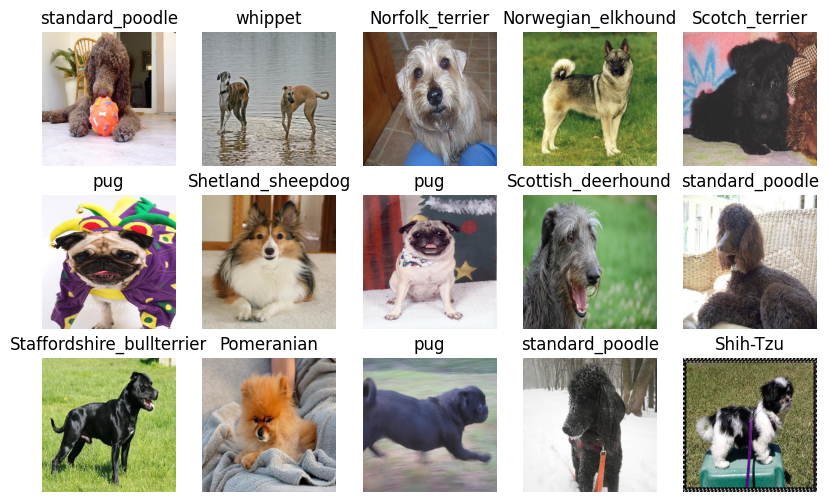

In [7]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [8]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False, pin_memory=True)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([32, 3, 224, 224])

In [9]:
def block(c_in, c_out, k=5, p=0, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # p=0, s=2
        torch.nn.ReLU(), # recomendable para las capas internas
        torch.nn.MaxPool2d(pk, stride=ps)# pk=2 , ps=1
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=40):
    super().__init__()

    # jugar con estos datos
    self.conv1 = block(n_channels, 512)
    self.conv2 = block(512, 256)
    self.conv3 = block(256, 128)
    self.conv4 = block(128, 64)
    self.fc = torch.nn.Linear(64 * 9 * 9, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    # print(x.shape)
    x = self.conv2(x)
    # print(x.shape)
    x = self.conv3(x)
    # print(x.shape)
    x = self.conv4(x)
    # print(x.shape)
    x = x.view(x.shape[0], -1) # aplananamiento
    # print(x.shape)
    x = self.fc(x) # fully conect
    # print(x.shape)
    return x

In [10]:
model = CNN()

output = model(torch.randn(32, 3, 224, 224))

In [11]:
from tqdm import tqdm
import numpy as np

# jugar con estos parametros
epoch = 20
tazaAprendizaje=1e-2

#  Toma como entrada el modelo de red neuronal (model), el dataloader que contiene los datos de entrenamiento
#y prueba (dataloader), y el número de épocas de entrenamiento (epochs).
def fit(model, dataloader, epochs= epoch):
    model.to(device) # Mueve el modelo a la GPU

    optimizer = torch.optim.Adam(model.parameters(), lr = tazaAprendizaje) # Crea un optimizador Adam para optimizar los parámetros del modelo
    criterion = torch.nn.CrossEntropyLoss() # Define una función de pérdida de entropía cruzada:
    #que se utilizará para calcular la pérdida durante el entrenamiento.

    for epoch in range(1, epochs+1): # Comienza un bucle de entrenamiento a lo largo de las épocas especificadas
        model.train()
        train_loss, train_acc = [], [] # listas
        bar = tqdm(dataloader['train'])
        for batch in bar:
          # Se obtienen los datos de entrada (X) y las etiquetas (y) del lote.
            X, y = batch
            X, y = X.to(device), y.to(device) # se mueve a la GPU

            optimizer.zero_grad() # Se inicializa el gradiente del optimizador

            #prediccion
            y_hat = model(X) # Se pasa la entrada a través del modelo para obtener las predicciones (y_hat).

            loss = criterion(y_hat, y) # Se calcula la pérdida entre las predicciones y las etiquetas verdaderas utilizando la función de pérdida de entropía cruzada.
            loss.backward() # retropropagación del gradiente
            optimizer.step() # Se actualizan los parámetros del modelo

# Se registran la pérdida y la precisión del entrenamiento en listas separadas.
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            # Se muestra el progreso del entrenamiento en la barra de progreso.
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []

        model.eval() #  se establece el modelo en modo de evaluación
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y) # Se calcula la pérdida y la precisión

# Se registran la pérdida y la precisión del entrenamiento en listas separadas.
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.2f} val_acc {np.mean(val_acc):.2f}")

      # pérdida promedio y la precisión promedio en el conjunto de entrenamiento y prueba para cada época
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.2f} val_loss {np.mean(val_loss):.2f} acc {np.mean(train_acc):.2f} val_acc {np.mean(val_acc):.2f}")

In [ ]:
model = CNN()
fit(model, dataloader)

loss 272.40317 acc 0.03184:  90%|████████▉ | 160/178 [23:01<02:33,  8.52s/it]

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

In [ ]:
plot_predictions(model, dataloader, 3, 5)
# Esto mostrará las primeras imágenes del primer lote del DataLoader de prueba:
#3 filas y 5 columnas de subgráficos.